In [1]:
import pandas as pd
import joblib

## Trigger Download

In [2]:
from IPython.display import FileLink, display, HTML, Javascript

def trigger_download(filename, my_id=0):
    # Create the FileLink object
    file_link = FileLink(filename)

    # Get the path of the file
    file_path = file_link.path

    # Create the HTML link
    html = f'<a id="download_link_{file_path}_{my_id}" href="{file_path}" download>{file_path}</a>'

    # Display the HTML link
    display(HTML(html))

    # Create and run the JavaScript to automatically click the link
    js_code = f'''
    var link = document.getElementById('download_link_{file_path}_{my_id}');
    link.click();
    '''
    display(Javascript(js_code))




## Add High Resolution and Low Resolution Data to our Trained Model

In [3]:
import joblib
import pandas as pd
import numpy as np
import torch

# Load datasets
high_res = pd.read_csv('/kaggle/input/test-gldas-data/resolution_2k.csv')
low_res = pd.read_csv('/kaggle/input/test-gldas-data/gldas_data_yearwise.csv')

# Load scalers and model
fitted_scaler = joblib.load('/kaggle/input/test-wights-for-groundhog/fitted_scaler.pkl')
standard_scaler = joblib.load('/kaggle/input/test-wights-for-groundhog/standard_scaler.pkl')
rf_model = joblib.load('/kaggle/input/test-wights-for-groundhog/upscaling_model.joblib')

# standard_scaler = joblib.load('/kaggle/input/updated-upsampling-weights/scaler_for_high_low.joblib')
# rf_model = joblib.load('/kaggle/input/updated-upsampling-weights/upscaling_model (1).joblib')

high_res['Original_Sy']=high_res.Sy
# Transform high-resolution data
high_res[fitted_scaler.feature_names_in_] = fitted_scaler.transform(high_res[fitted_scaler.feature_names_in_])

# Merge datasets
data = high_res.merge(low_res, on=['GLDAS_SerialID', 'Year']).rename(columns={'POINT_X_x': 'POINT_X', 'POINT_Y_x': 'POINT_Y'})

# Scale numerical features
X_numerical_scaled = standard_scaler.transform(data[standard_scaler.feature_names_in_])

# Encode categorical data
X_cat = data[['lithology', 'lithology_MAJORITY']].astype('string')
X_cat_encoded = pd.get_dummies(X_cat)

# Prepare final input tensor
X_final = torch.tensor(np.hstack([X_numerical_scaled, X_cat_encoded]).astype('float32'))

# Predict
pred = rf_model.predict(X_final)
high_res['Sy'] = high_res['Sy'] if 'Sy' in high_res.columns else 1  # Ensure Sy column exists
recharge = (pred[:, 1] - pred[:, 0]) * 100 * data['Original_Sy']

# Display feature names and feature importance
feature_names = list(standard_scaler.feature_names_in_) + list(X_cat_encoded.columns)
feature_importance = rf_model.feature_importances_

# Create DataFrame for easier viewing
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display feature importance
print(importance_df)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   18.0s


                     Feature    Importance
10                 elevation  2.417721e-01
8   lithology_clay_thickness  1.635921e-01
2                         Sy  1.581643e-01
11          drainage_density  4.707785e-02
3                        STI  2.854978e-02
..                       ...           ...
61      lithology_MAJORITY_1  1.372752e-05
71      lithology_MAJORITY_2  8.290452e-06
75     lithology_MAJORITY_24  4.010798e-06
38              lithology_13  9.265656e-07
47              lithology_21  3.985222e-08

[85 rows x 2 columns]


## Assign those Values

In [4]:
data['Max GWL']=pred[:,1]
data['Min GWL']=pred[:,0]
data['recharge']=recharge

# Visualiztion

## Function for plotting

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

def plot_column_as_points(data, column_values, column_name,point_size=5):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Extract values for the current column
    longitudes = data.POINT_X
    latitudes = data.POINT_Y

    # Define your ranges and corresponding colors
    boundaries = [0, 5.3, 7.6, 9.8, 11.3, 15, 20.5, 26, 35.5, 58]
    cmap_colors = [
        'blue',         # below 0
        '#a8e1e0',      # < 5.3 (light blue)
        '#66c18a',      # 5.3 to < 7.6 (light green)
        '#3b7a3d',      # 7.6 to < 9.8 (dark green)
        '#f3d5a4',      # 9.8 to < 11.3 (light purple)
        '#b299ca',      # 11.3 to < 15 (purple)
        '#e4a6a3',      # 15 to < 20.5 (-0.5 to 0d)
        '#d35d60',      # 20.5 to < 26 (red)
        '#a0322e',      # 26 to < 35.5 (dark red)
        '#330e0f',      # 35.5 to < 58 (dark gray)
    ]

    # Create a custom colormap using LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
    norm = BoundaryNorm(boundaries, cmap.N)

    # Scatter plot with discrete color mapping
    sc = ax.scatter(longitudes, latitudes, c=column_values, cmap=cmap, norm=norm, s=point_size, edgecolor='None')

    # Add a color bar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(f'{column_name}')

    # Add title and labels with increased font size
    ax.set_title(f'{column_name}', fontsize=16)  # Increase title font size
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Save the plot to file
    plt.savefig(f'{column_name}.png', dpi=300)
    print(column_name)
    plt.show()

# Example Usage
# Assuming data is a DataFrame containing column_name values and 'longitudes', 'latitudes' as separate arrays
# plot_column_as_points(data, column_values, 'GWL_Column')


## Visualizing Maximum and Minimum GWL (BGL) in meters

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2003 (meters)


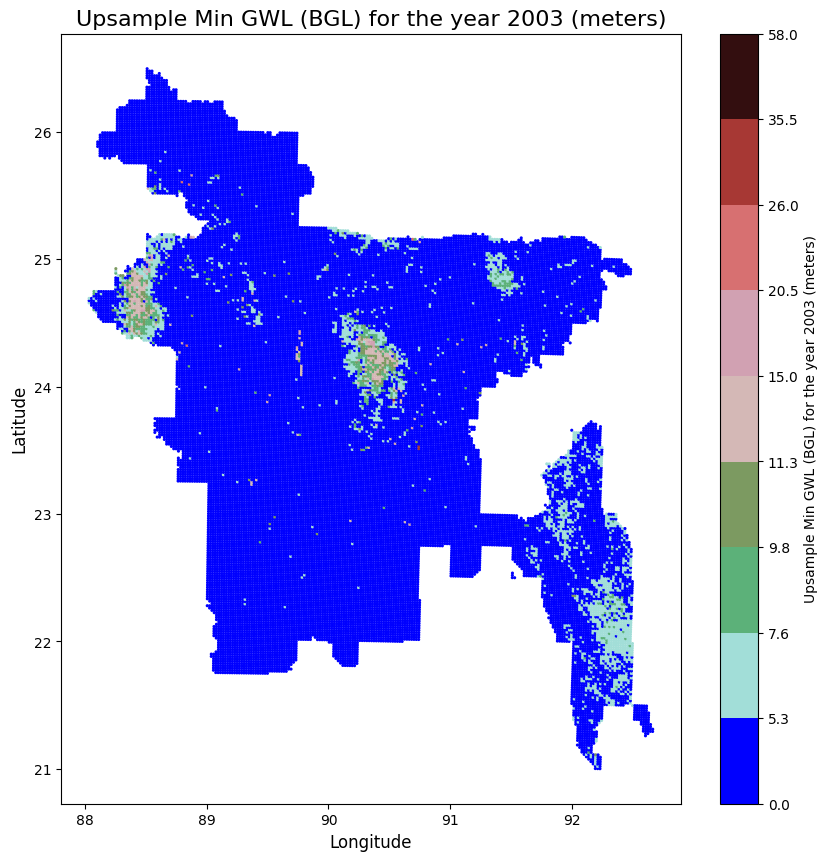

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2003 (meters)


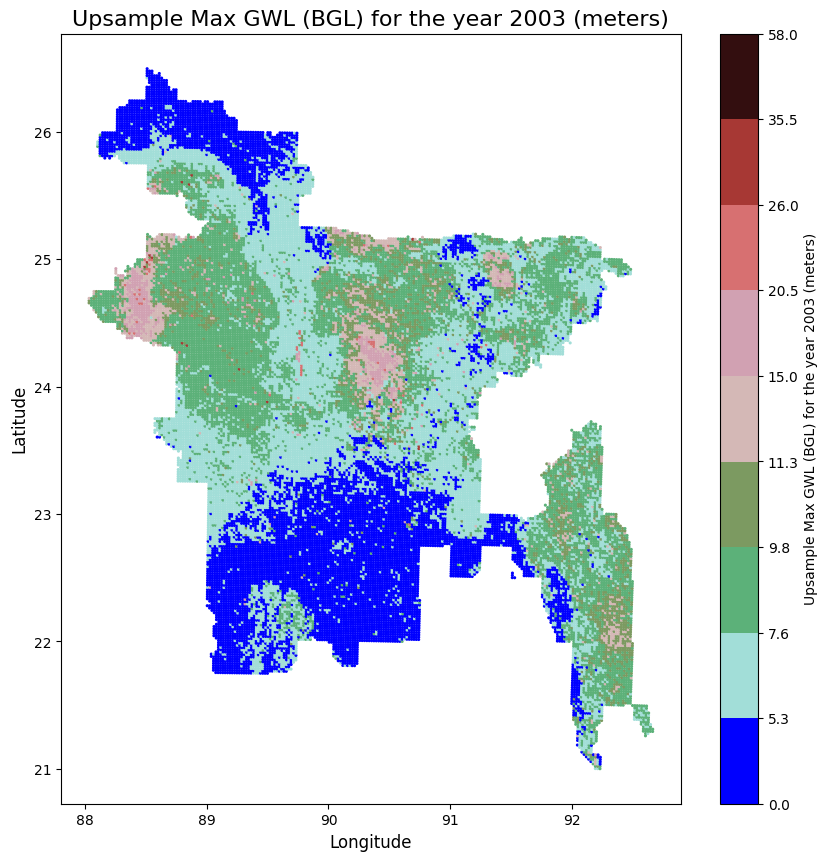

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2004 (meters)


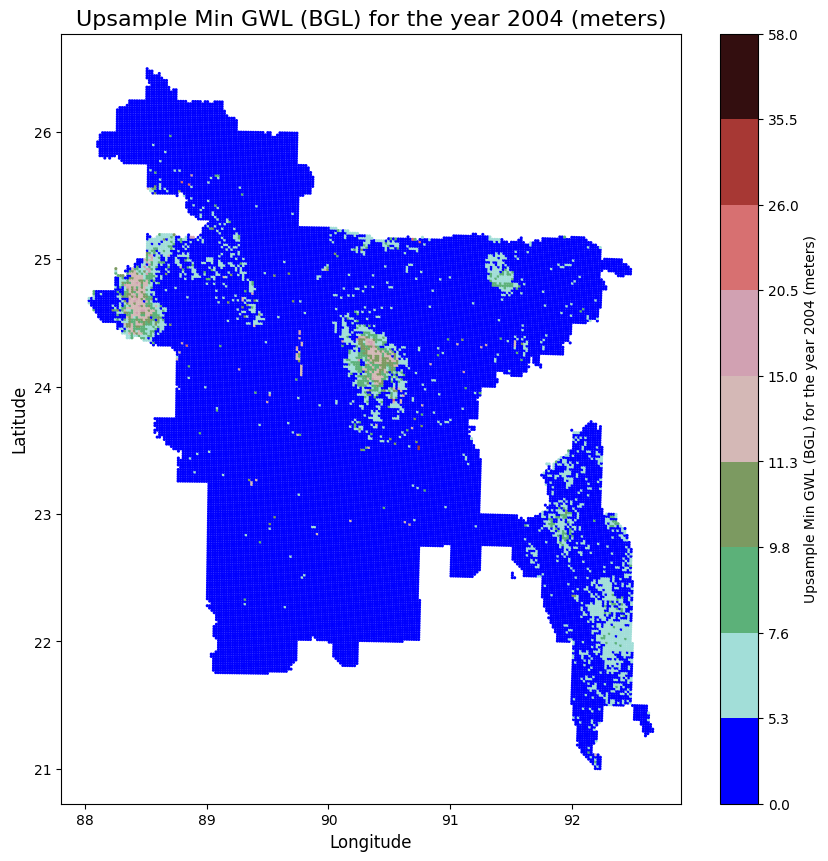

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2004 (meters)


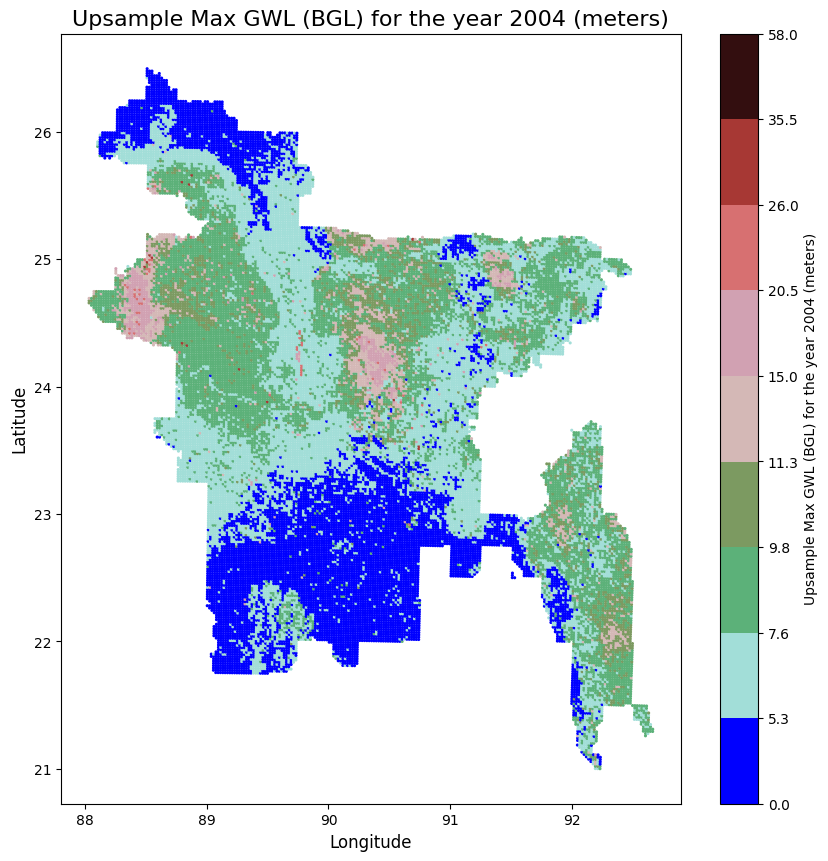

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2005 (meters)


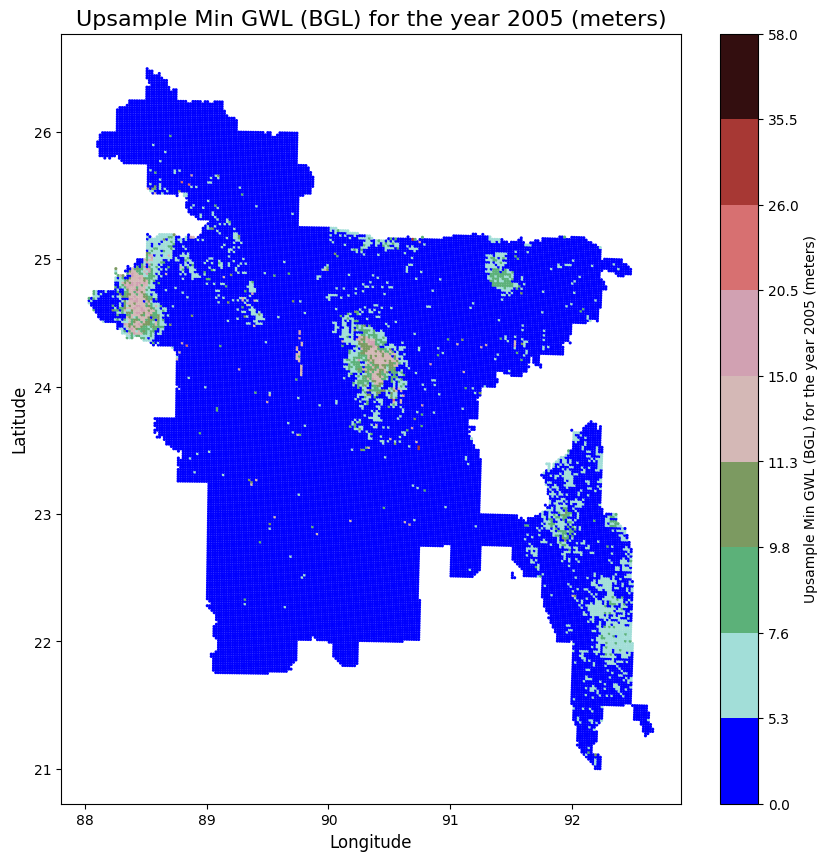

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2005 (meters)


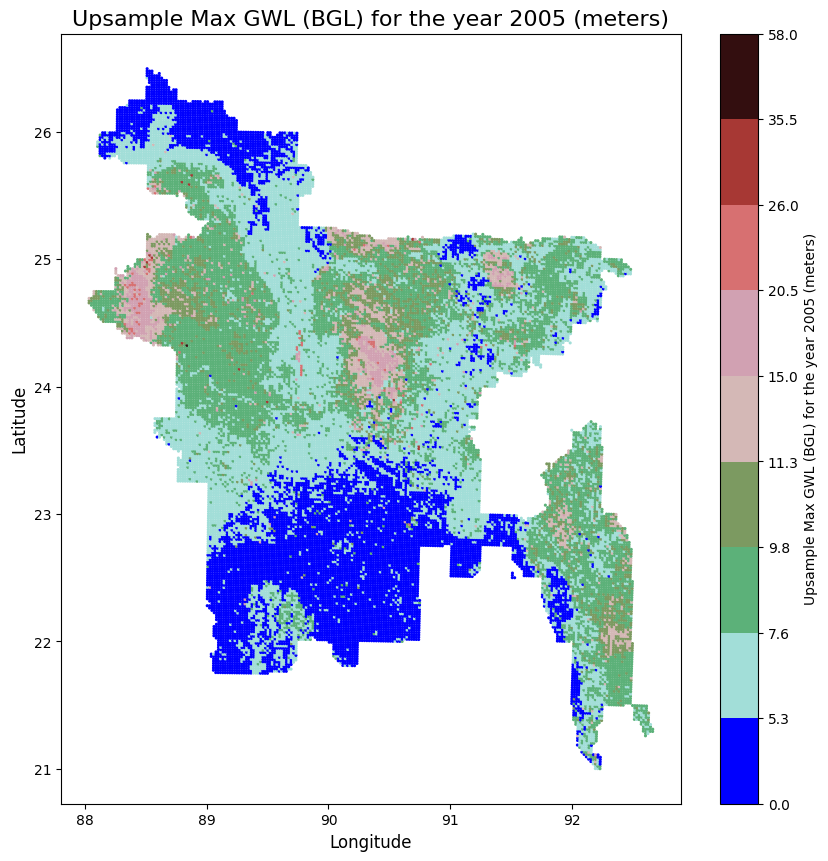

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2006 (meters)


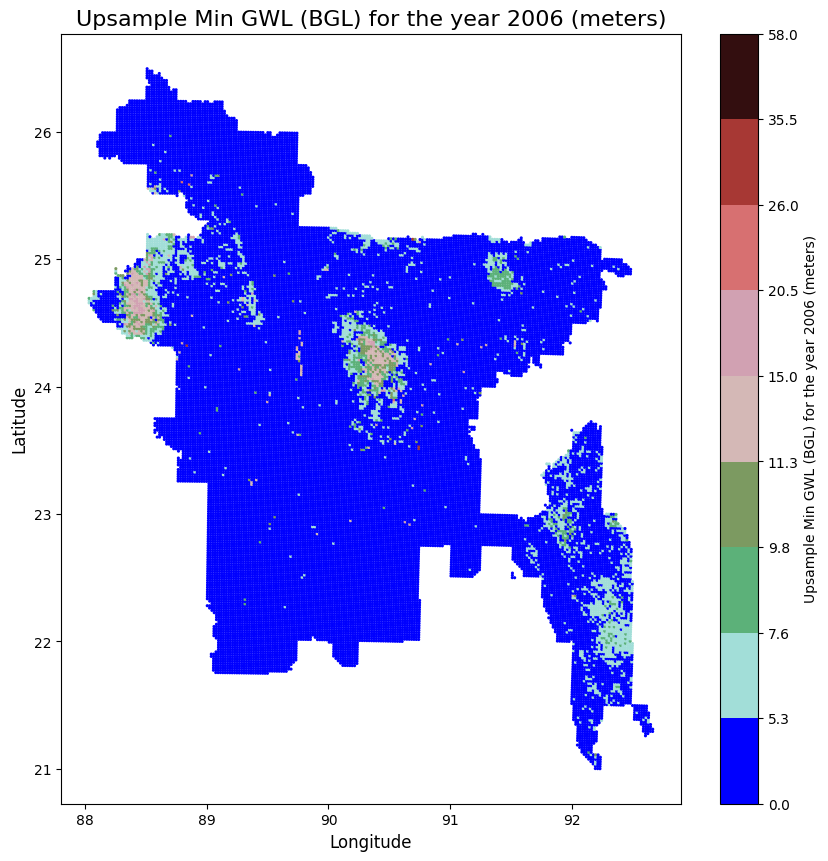

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2006 (meters)


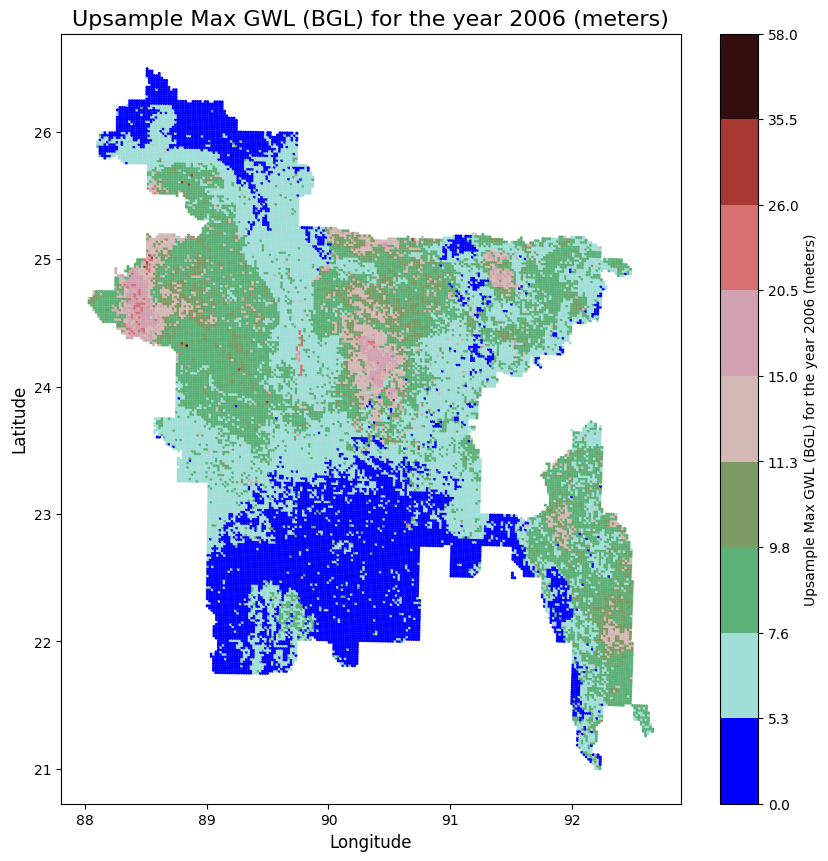

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2007 (meters)


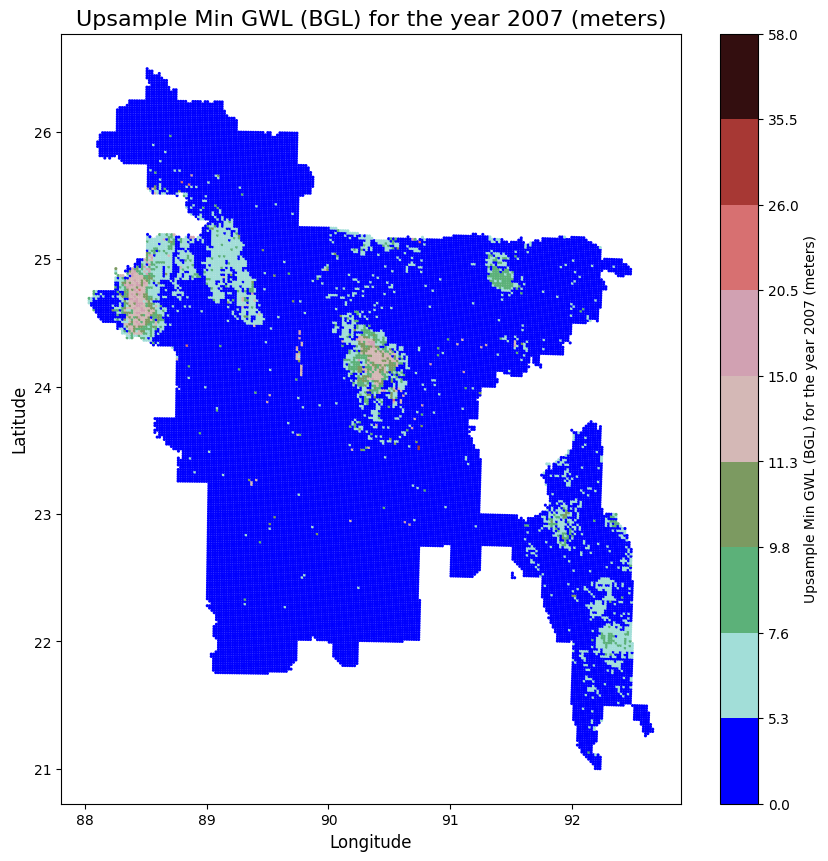

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2007 (meters)


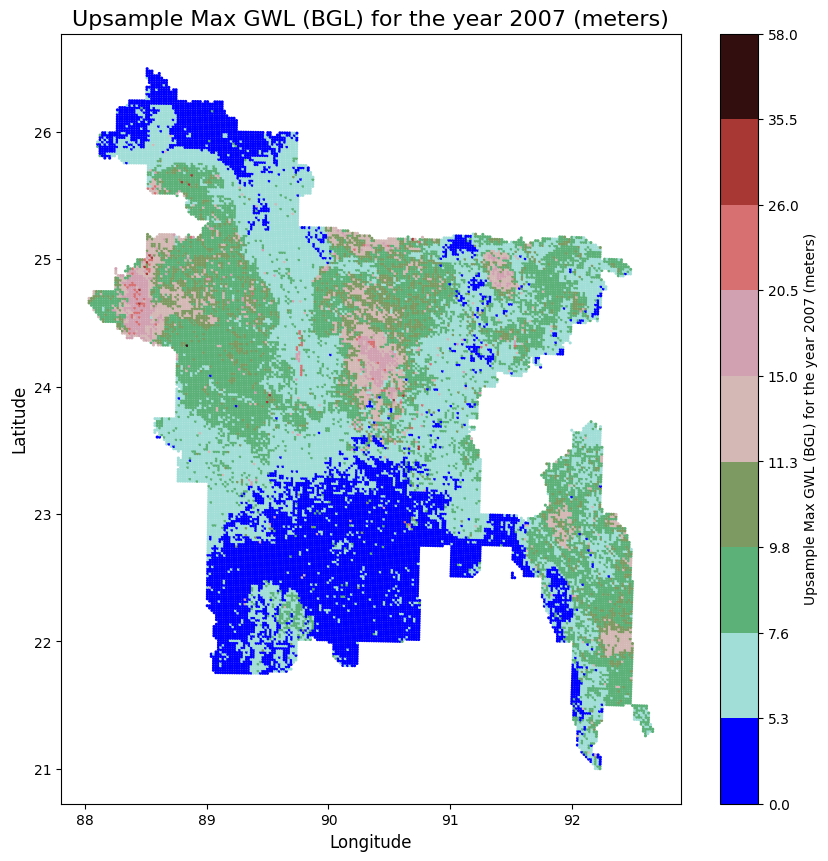

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2008 (meters)


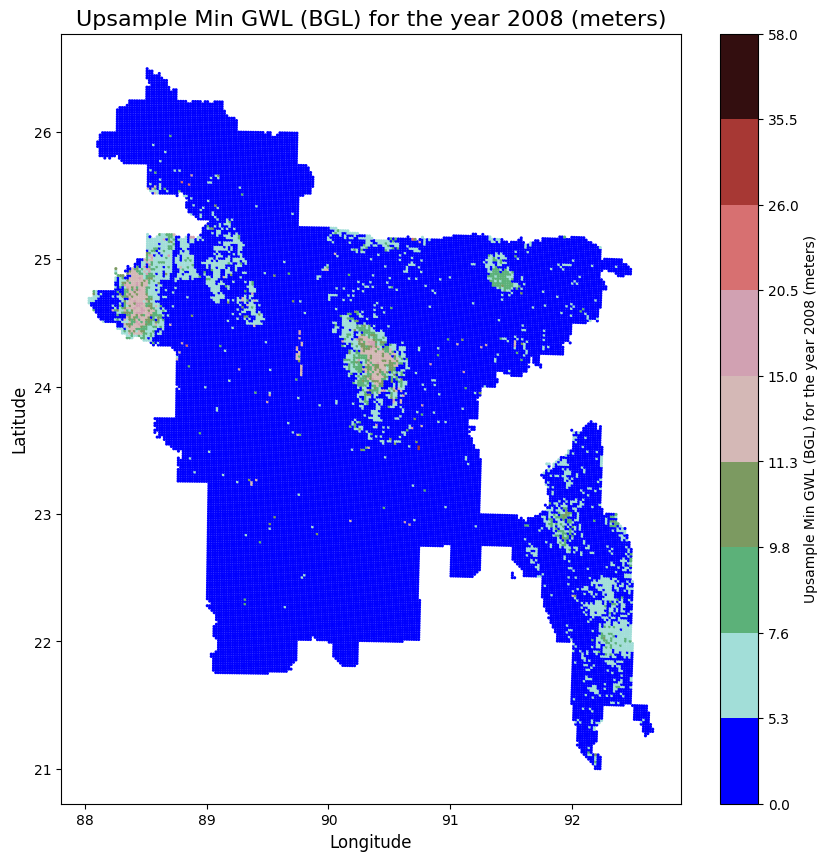

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2008 (meters)


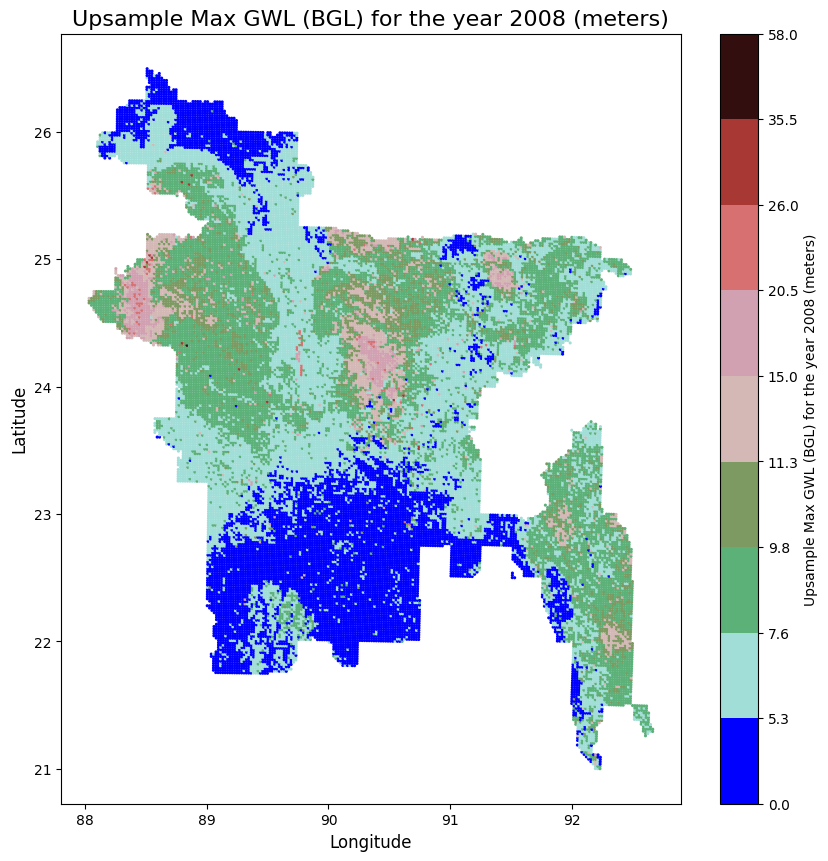

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2009 (meters)


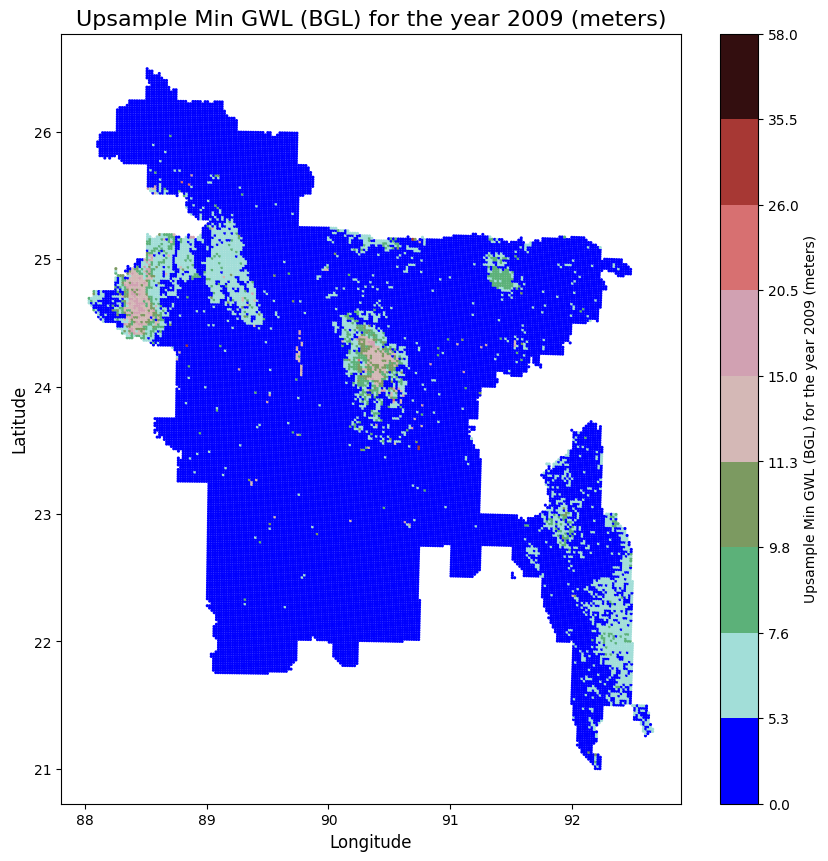

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2009 (meters)


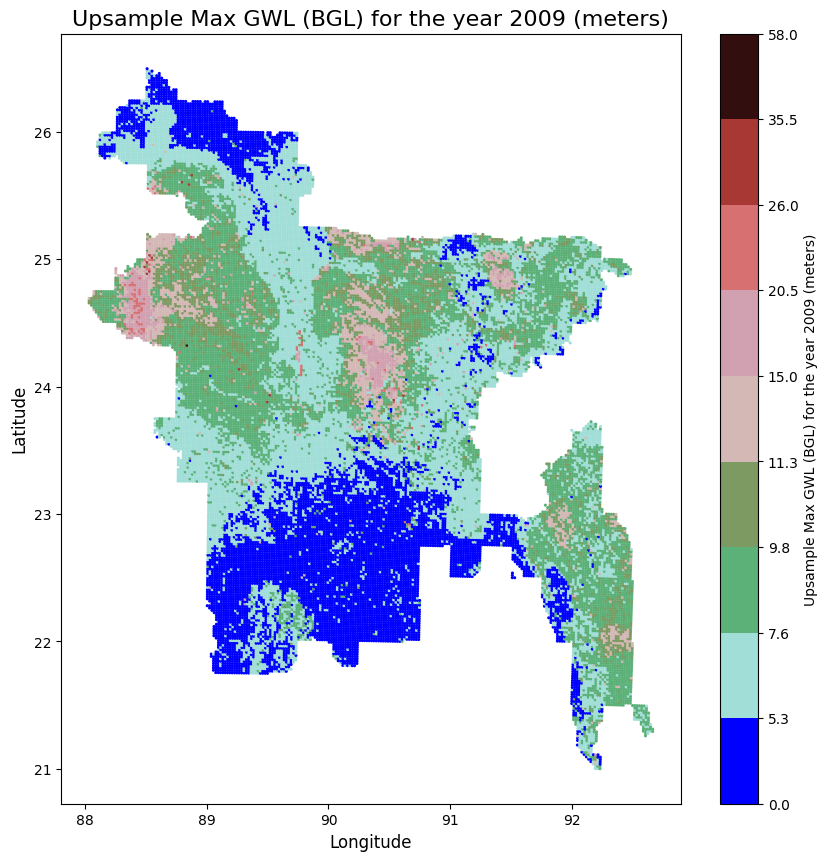

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2010 (meters)


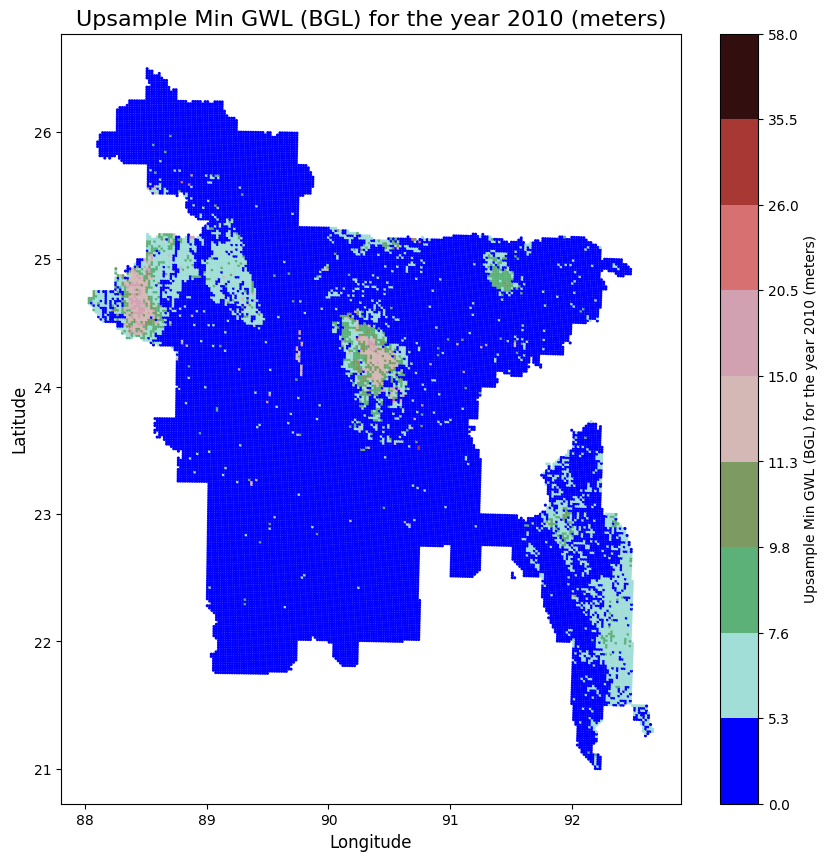

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2010 (meters)


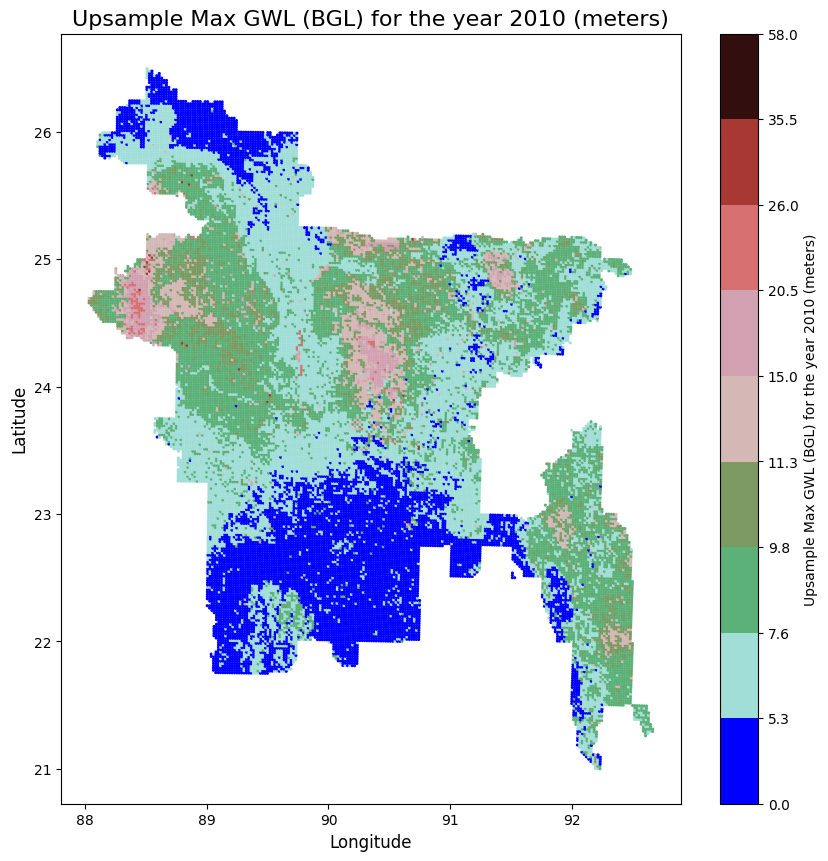

(32985, 48) (32985,)
Upsample Min GWL (BGL) for the year 2011 (meters)


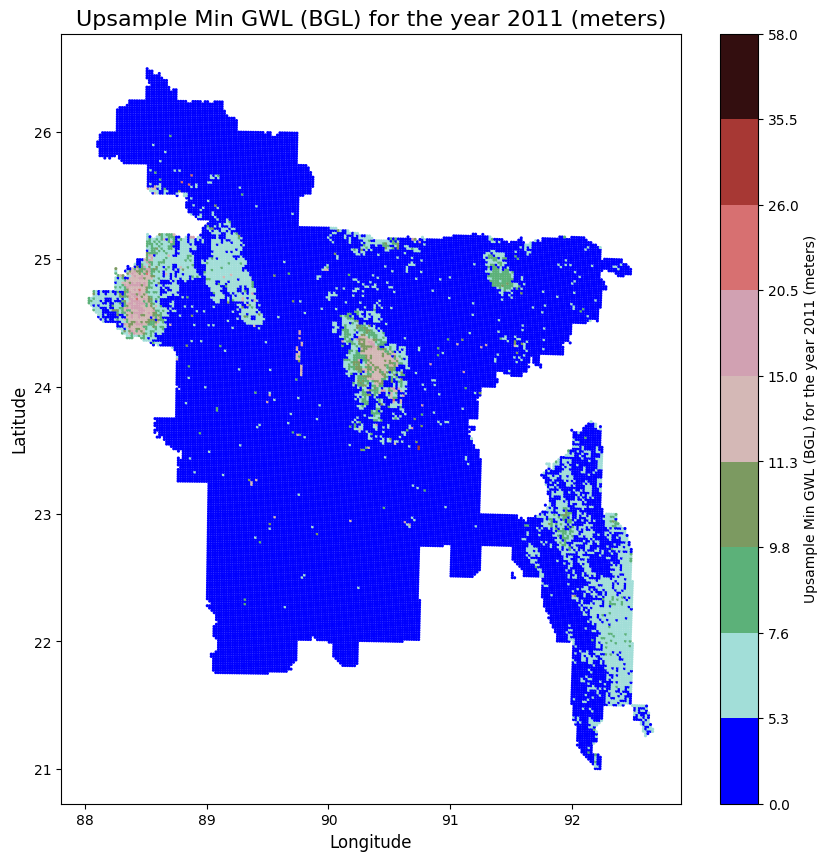

(32985, 48) (32985,)
Upsample Max GWL (BGL) for the year 2011 (meters)


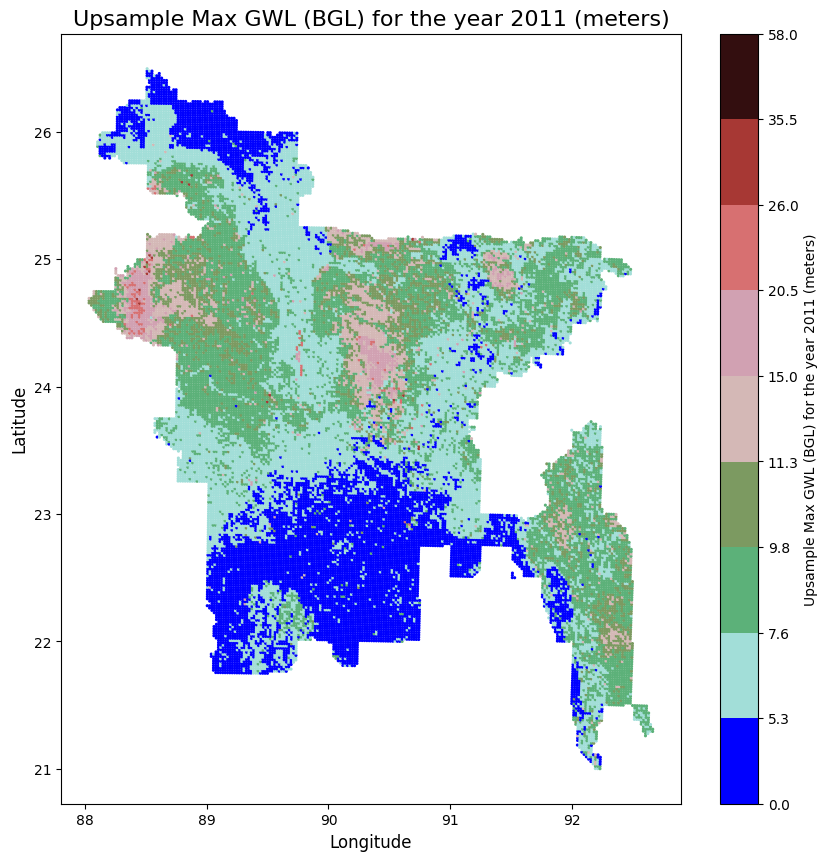

(32985, 48) (32985,)


KeyboardInterrupt: 

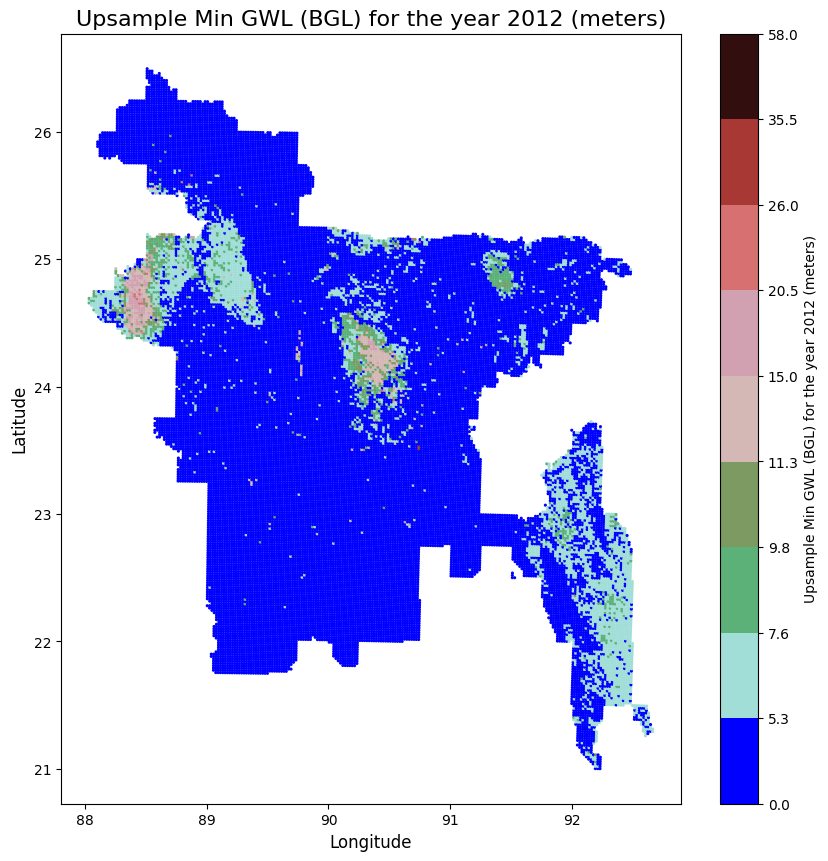

In [6]:
cur_data=data
# cur_data=psuedo_data
for year in cur_data.Year.unique():
#     if year<=2001:
#         continue
    
    for mode in ['Min GWL','Max GWL']:
        A=cur_data[cur_data.Year==year].sort_values(by=['POINT_X','POINT_Y'])
        B=cur_data[cur_data.Year==year-1].sort_values(by=['POINT_X','POINT_Y'])
        x=A[mode].values.reshape(-1)
#         y=B['min_gwl'].values.reshape(-1)
        print(A.shape,x.shape)
        plot_column_as_points(A,x,f'Upsample {mode} (BGL) for the year {year} (meters)')

## Function for plotting GLDAS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

def plot_column_as_points(data, column_values, column_name,point_size=5):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Extract values for the current column
    longitudes = data.POINT_X
    latitudes = data.POINT_Y

    # Define your ranges and corresponding colors
    boundaries = [0, 500, 700, 900, 1100, 1300, 1500, 1700, 1900,2000 ]
    cmap_colors = [
        'blue',         # below 0
        '#a8e1e0',      # < 5.3 (light blue)
        '#66c18a',      # 5.3 to < 7.6 (light green)
        '#3b7a3d',      # 7.6 to < 9.8 (dark green)
        '#f3d5a4',      # 9.8 to < 11.3 (light purple)
        '#b299ca',      # 11.3 to < 15 (purple)
        '#e4a6a3',      # 15 to < 20.5 (-0.5 to 0d)
        '#d35d60',      # 20.5 to < 26 (red)
        '#a0322e',      # 26 to < 35.5 (dark red)
        '#330e0f',      # 35.5 to < 58 (dark gray)
    ]

    # Create a custom colormap using LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
    norm = BoundaryNorm(boundaries, cmap.N)

    # Scatter plot with discrete color mapping
    sc = ax.scatter(longitudes, latitudes, c=column_values, cmap=cmap, norm=norm, s=point_size, edgecolor='None')

    # Add a color bar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(f'{column_name}')

    # Add title and labels with increased font size
    ax.set_title(f'{column_name}', fontsize=16)  # Increase title font size
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Save the plot to file
    plt.savefig(f'{column_name}.png', dpi=300)
    print(column_name)
    plt.show()

# Example Usage
# Assuming data is a DataFrame containing column_name values and 'longitudes', 'latitudes' as separate arrays
# plot_column_as_points(data, column_values, 'GWL_Column')


In [ ]:
low_res.Max_GWS.max()

In [ ]:
cur_data=data
# cur_data=psuedo_data
for year in cur_data.Year.unique():
#     if year<=2001:
#         continue
    
    for mode in ['Min_GWS','Max_GWS']:
        A=cur_data[cur_data.Year==year].sort_values(by=['POINT_X','POINT_Y'])
        B=cur_data[cur_data.Year==year-1].sort_values(by=['POINT_X','POINT_Y'])
        x=A[mode].values.reshape(-1)
#         y=B['min_gwl'].values.reshape(-1)
        print(A.shape,x.shape)
        plot_column_as_points(A,x,f'GLDAS low res {mode.replace("_"," ")}  for the year {year} (mm)')

## Function for plotting Recharge

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap

def plot_column_as_points(data,column_values,column_name):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Extract values for the current column
    longitudes=data.POINT_X
    latitudes=data.POINT_Y

    # Define your ranges and corresponding colors
    boundaries = [0, 5.3, 7.6, 9.8, 11.3, 15, 20.5, 26, 35.5, 58, 60, 70, 80, 90, 100, 150]
    cmap_colors = [
        'blue',         # below 0
        '#a8e1e0',      # < 5.3 (light blue)
        '#66c18a',      # 5.3 to < 7.6 (light green)
        '#3b7a3d',      # 7.6 to < 9.8 (dark green)
        '#f3d5a4',      # 9.8 to < 11.3 (light purple)
        '#b299ca',      # 11.3 to < 15 (purple)
        '#e4a6a3',      # 15 to < 20.5 (-0.5 to 0d)
        '#d35d60',      # 20.5 to < 26 (red)
        '#a0322e',      # 26 to < 35.5 (dark red)
        '#330e0f',      # 35.5 to < 58 (dark gray)
        '#4f4d4d',      # 58 to < 60 (gray)
        '#7d7b7b',      # 60 to < 70 (light gray)
        '#a9a8a8',      # 70 to < 80 (lighter gray)
        '#c2c0c0',      # 80 to < 90 (lightest gray)
        '#dbdbdb',      # 90 to < 100 (almost white)
        'black'         # 100+ (black)
    ]

    # Create a custom colormap using LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors)
    norm = BoundaryNorm(boundaries, cmap.N)

    # Scatter plot with discrete color mapping
    sc = ax.scatter(longitudes, latitudes, c=column_values, cmap=cmap, norm=norm, s=5, edgecolor='None')

    # Add a color bar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(f'{column_name} ')

    # Add title and labels
    ax.set_title(f'{column_name} GWL Points ', fontsize=16)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Save the plot to file
    plt.savefig(f'{column_name}.png', dpi=300)
    print(column_name)
    plt.show()

# Example Usage
# Assuming data is a DataFrame containing column_name values and 'longitudes', 'latitudes' as separate arrays
# plot_column_as_points('GWL_Column', data, longitudes, latitudes)


## Visulaizing The Recharge

In [ ]:
cur_data=data
# cur_data=psuedo_data
for year in cur_data.Year.unique():

    A=cur_data[cur_data.Year==year].sort_values(by=['POINT_X','POINT_Y'])
    B=cur_data[cur_data.Year==year-1].sort_values(by=['POINT_X','POINT_Y'])
    x=A['recharge'].values.reshape(-1)
#         y=B['min_gwl'].values.reshape(-1)
    print(A.shape,x.shape)
    plot_column_as_points(A,x,f'Upsample Recharge for the year {year} (centimeters)')

## Zip 

In [ ]:
!zip GLDAS_GWS.zip *GWS*


In [ ]:
trigger_download('GLDAS_GWS.zip')

In [ ]:
!zip Upsampled_GWL.zip *GWL*
!zip Upsampled_Recharge.zip *Recharge*

In [ ]:
trigger_download('Upsampled_GWL.zip')
trigger_download('Upsampled_Recharge.zip')

# Visualizing the Trend 

## Visualizing the Trend of Recharge

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import theilslopes

# Sample dataframe
df = data  # Replace with actual data

# Group data by POINT_X and POINT_Y and calculate Sen's Slope in one step
def calculate_sens_slope(group):
    # Perform Sen's Slope on year vs. recharge if there's enough data
    if group['Year'].nunique() > 1:
        slope, intercept, lower, upper = theilslopes(group['recharge'], group['Year'])
        return round(slope, 2)  # Round slope to 2 decimal places
    return np.nan  # Not enough data

# Calculate the Sen's Slope for each group and reset index
trends_df = df.groupby(['POINT_X', 'POINT_Y']).apply(calculate_sens_slope).reset_index(name='sens_slope')

# Drop rows with NaN values in sens_slope, as these indicate insufficient data for a trend
trends_df = trends_df.dropna(subset=['sens_slope'])

# Define bins and labels for categorizing slope values
bins = [-1, -0.5,-0.3, -0.05,0.05, 0.5, 1]
labels = ['-1 to -0.5', '-0.5 to -0.3','-0.3 to -0.05','-0.05 to 0.05' ,'0.05 to 0.5', '0.5 to 1']
trends_df['slope_category'] = pd.cut(trends_df['sens_slope'], bins=bins, labels=labels)

# Define the custom color palette for discrete categories
custom_palette = {
    '-1 to -0.5': '#000000',     # <-0.5 for strong negative trend
     '-0.5 to -0.3': '#BB0000',     # <-0.5 for strong negative trend
    '-0.3 to -0.05': '#FFA07A',    # -0.5 to 0d for moderate negative trend
    '-0.05 to 0.05': "#FFFFFF",
    '0.05 to 0.5': '#ADD8E6',   # 0 to 0.5 for moderate positive trend
    '0.5 to 1': '#00008B'     # Deep blue for strong positive trend
}

# Plot the scatter plot with POINT_X and POINT_Y and slope_category as hue
plt.figure(figsize=(8, 10))
scatter = sns.scatterplot(
    data=trends_df,
    x='POINT_X',
    y='POINT_Y',
    hue='slope_category',
    palette=custom_palette,
    edgecolor=None
)

# Add title and labels
plt.title("Recharge Trend (Sen's Slope cm/year) for Bangladesh (2003 to 2022)",fontsize=16)
plt.xlabel('POINT_X')
plt.ylabel('POINT_Y')
plt.legend(title="Slope Category", loc='upper right')
plt.tight_layout()
plt.savefig('discrete_sens_slope_recharge_trend.png',dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Sample dataframe
df = data  # Replace with actual data

# Group data by POINT_X and POINT_Y and calculate the Mann-Kendall trend in one step
def calculate_mann_kendall_trend(group):
    # Perform the Mann-Kendall test on year vs. recharge if there's enough data
    if group['Year'].nunique() > 1:
        tau, p_value = kendalltau(group['Year'], group['recharge'])
        # Interpret trend direction based on tau value
        if p_value < 0.05:  # Assuming significance level of 0.05
            return round(tau, 2)  # Round tau to 2 decimal places
        else:
            return np.nan  # No significant trend
    return np.nan  # Not enough data

# Calculate the trend for each group and reset index
trends_df = df.groupby(['POINT_X', 'POINT_Y']).apply(calculate_mann_kendall_trend).reset_index(name='trend_tau')

# Create a categorical column based on the Mann-Kendall tau value
def categorize_trend(tau):
    if tau > 0:
        return 'Positive Trend'
    elif tau < 0:
        return 'Negative Trend'
    else:
        return 'Zero Trend'

trends_df['trend_category'] = trends_df['trend_tau'].apply(categorize_trend)

# Define the custom color palette for discrete categories
custom_palette = {
    'Positive Trend': 'blue',
    'Negative Trend': 'red',
    'Zero Trend': 'grey'
}

# Plot the scatter plot with POINT_X and POINT_Y and trend_category as hue
plt.figure(figsize=(8, 10))
scatter = sns.scatterplot(
    data=trends_df,
    x='POINT_X',
    y='POINT_Y',
    hue='trend_category',
    palette=custom_palette,
    edgecolor=None
)

plt.title('Trend of Upsampled Recharge Change (Mann Kandall) for Bangladesh from 2003 to 2022', fontsize=16)
plt.xlabel('POINT_X')
plt.ylabel('POINT_Y')
plt.legend(title='Trend Category')
plt.tight_layout()
plt.savefig('recharge_trend_mann_kandall.png',dpi=300,bbox_inches='tight')
plt.show()


## Visualizing the Trend  of Min GWL

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import theilslopes

# Sample dataframe
df = data  # Replace with actual data

# Group data by POINT_X and POINT_Y and calculate Sen's Slope in one step
def calculate_sens_slope(group):
    # Perform Sen's Slope on year vs. recharge if there's enough data
    if group['Year'].nunique() > 1:
        slope, intercept, lower, upper = theilslopes(group['Min GWL'], group['Year'])
        return round(slope, 2)  # Round slope to 2 decimal places
    return np.nan  # Not enough data

# Calculate the Sen's Slope for each group and reset index
trends_df = df.groupby(['POINT_X', 'POINT_Y']).apply(calculate_sens_slope).reset_index(name='sens_slope')

# Drop rows with NaN values in sens_slope, as these indicate insufficient data for a trend
trends_df = trends_df.dropna(subset=['sens_slope'])

# Define bins and labels for categorizing slope values
bins = [-1, -0.5, 0, 0.5, 1]
labels = ['-1 to -0.5', '-0.5 to 0', '0 to 0.5', '0.5 to 1']
trends_df['slope_category'] = pd.cut(trends_df['sens_slope'], bins=bins, labels=labels)

# Define the custom color palette for discrete categories
custom_palette = {
    '-1 to -0.5': '#8B0000',     # <-0.5 for strong negative trend
    '-0.5 to 0': '#FFA07A',    # -0.5 to 0d for moderate negative trend
    '0 to 0.5': '#ADD8E6',   # 0 to 0.5 for moderate positive trend
    '0.5 to 1': '#00008B'     # Deep blue for strong positive trend
}

# Plot the scatter plot with POINT_X and POINT_Y and slope_category as hue
plt.figure(figsize=(8, 10))
scatter = sns.scatterplot(
    data=trends_df,
    x='POINT_X',
    y='POINT_Y',
    hue='slope_category',
    palette=custom_palette,
    edgecolor=None
)

# Add title and labels
plt.title("Min GWL Trend (Sen's Slope meters/year) for Bangladesh (2003 to 2022)", fontsize=16)
plt.xlabel('POINT_X')
plt.ylabel('POINT_Y')
plt.legend(title="Slope Category", loc='upper right')
plt.tight_layout()
plt.savefig('discrete_sens_slope_min_gwl_trend.png',dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Sample dataframe
df = data  # Replace with actual data

# Group data by POINT_X and POINT_Y and calculate the Mann-Kendall trend in one step
def calculate_mann_kendall_trend(group):
    # Perform the Mann-Kendall test on year vs. recharge if there's enough data
    if group['Year'].nunique() > 1:
        tau, p_value = kendalltau(group['Year'], group['Min GWL'])
        # Interpret trend direction based on tau value
        if p_value < 0.05:  # Assuming significance level of 0.05
            return round(tau, 2)  # Round tau to 2 decimal places
        else:
            return np.nan  # No significant trend
    return np.nan  # Not enough data

# Calculate the trend for each group and reset index
trends_df = df.groupby(['POINT_X', 'POINT_Y']).apply(calculate_mann_kendall_trend).reset_index(name='trend_tau')

# Create a categorical column based on the Mann-Kendall tau value
def categorize_trend(tau):
    if tau > 0:
        return 'Positive Trend'
    elif tau < 0:
        return 'Negative Trend'
    else:
        return 'Zero Trend'

trends_df['trend_category'] = trends_df['trend_tau'].apply(categorize_trend)

# Define the custom color palette for discrete categories
custom_palette = {
    'Positive Trend': 'blue',
    'Negative Trend': 'red',
    'Zero Trend': 'grey'
}

# Plot the scatter plot with POINT_X and POINT_Y and trend_category as hue
plt.figure(figsize=(8, 10))
scatter = sns.scatterplot(
    data=trends_df,
    x='POINT_X',
    y='POINT_Y',
    hue='trend_category',
    palette=custom_palette,
    edgecolor=None
)

plt.title('Trend of Upsampled Min GWL Change (Mann Kandall) for Bangladesh from 2003 to 2022', fontsize=16)
plt.xlabel('POINT_X')
plt.ylabel('POINT_Y')
plt.legend(title='Trend Category')
plt.tight_layout()
plt.savefig('min_gwl_trend_mann_kandall.png',dpi=300,bbox_inches='tight')
plt.show()


## Visualizing the Trend  of Max GWL

/tmp/ipykernel_30/1155033557.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trends_df = df.groupby(['POINT_X', 'POINT_Y']).apply(calculate_sens_slope).reset_index(name='sens_slope')


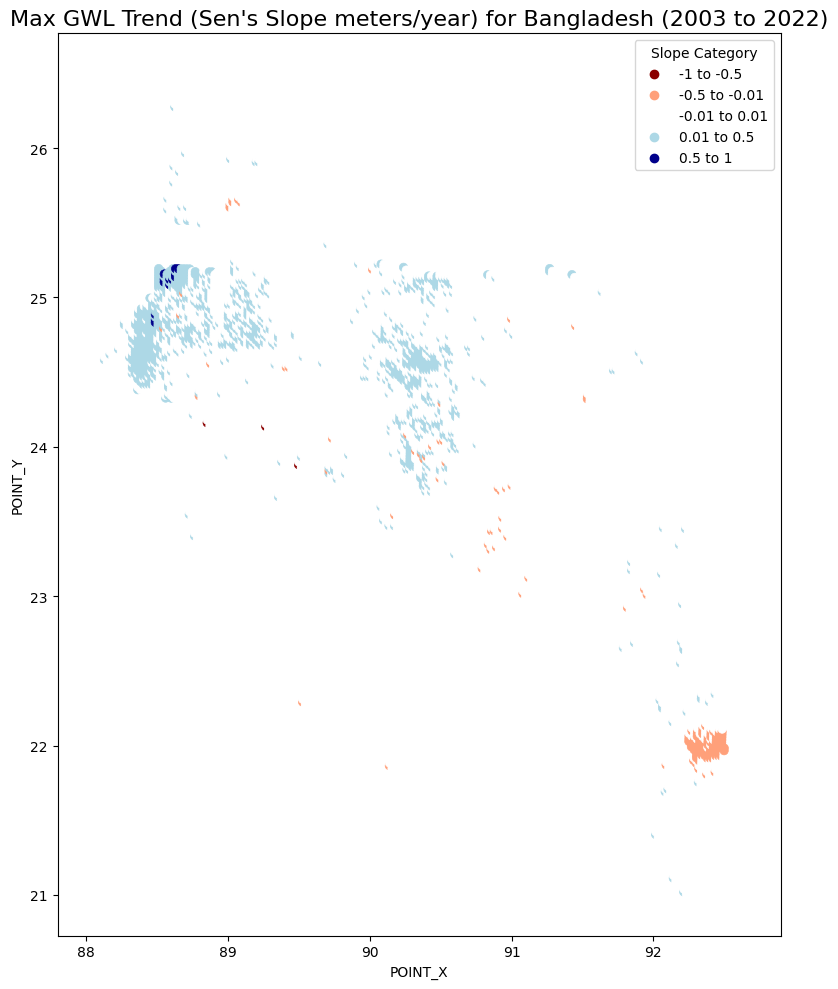

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import theilslopes

# Sample dataframe
df = data  # Replace with actual data

# Group data by POINT_X and POINT_Y and calculate Sen's Slope in one step
def calculate_sens_slope(group):
    # Perform Sen's Slope on year vs. recharge if there's enough data
    if group['Year'].nunique() > 1:
        slope, intercept, lower, upper = theilslopes(group['Max GWL'], group['Year'])
        return round(slope, 2)  # Round slope to 2 decimal places
    return np.nan  # Not enough data

# Calculate the Sen's Slope for each group and reset index
trends_df = df.groupby(['POINT_X', 'POINT_Y']).apply(calculate_sens_slope).reset_index(name='sens_slope')

# Drop rows with NaN values in sens_slope, as these indicate insufficient data for a trend
trends_df = trends_df.dropna(subset=['sens_slope'])

# Define bins and labels for categorizing slope values
bins = [-1, -0.5, -0.1,0.1, 0.5, 1]
negiligible=0.01
labels = ['-1 to -0.5', f'-0.5 to -{negiligible}',f'-{negiligible} to {negiligible}', f'{negiligible} to 0.5', '0.5 to 1']
trends_df['slope_category'] = pd.cut(trends_df['sens_slope'], bins=bins, labels=labels)

# Define the custom color palette for discrete categories
custom_palette = {
    '-1 to -0.5': '#8B0000',     # <-0.5 for strong negative trend
     f'-0.5 to -{negiligible}': '#FFA07A',    # -0.5 to 0d for moderate negative trend
    f'-{negiligible} to {negiligible}':'#FFFFFF',
    f'{negiligible} to 0.5': '#ADD8E6',   # 0 to 0.5 for moderate positive trend
    '0.5 to 1': '#00008B'     # Deep blue for strong positive trend
}

# Plot the scatter plot with POINT_X and POINT_Y and slope_category as hue
plt.figure(figsize=(8, 10))
scatter = sns.scatterplot(
    data=trends_df,
    x='POINT_X',
    y='POINT_Y',
    hue='slope_category',
    palette=custom_palette,
    edgecolor=None
)

# Add title and labels
plt.title("Max GWL Trend (Sen's Slope meters/year) for Bangladesh (2003 to 2022)", fontsize=16)
plt.xlabel('POINT_X')
plt.ylabel('POINT_Y')
plt.legend(title="Slope Category", loc='upper right')
plt.tight_layout()
plt.savefig('discrete_sens_slope_max_gwl_trend.png',dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau

# Sample dataframe
df = data  # Replace with actual data

# Group data by POINT_X and POINT_Y and calculate the Mann-Kendall trend in one step
def calculate_mann_kendall_trend(group):
    # Perform the Mann-Kendall test on year vs. recharge if there's enough data
    if group['Year'].nunique() > 1:
        tau, p_value = kendalltau(group['Year'], group['Max GWL'])
        # Interpret trend direction based on tau value
        if p_value < 0.05:  # Assuming significance level of 0.05
            return round(tau, 2)  # Round tau to 2 decimal places
        else:
            return np.nan  # No significant trend
    return np.nan  # Not enough data

# Calculate the trend for each group and reset index
trends_df = df.groupby(['POINT_X', 'POINT_Y']).apply(calculate_mann_kendall_trend).reset_index(name='trend_tau')

# Create a categorical column based on the Mann-Kendall tau value
def categorize_trend(tau):
    if tau > 0:
        return 'Positive Trend'
    elif tau < 0:
        return 'Negative Trend'
    else:
        return 'Zero Trend'

trends_df['trend_category'] = trends_df['trend_tau'].apply(categorize_trend)

# Define the custom color palette for discrete categories
custom_palette = {
    'Positive Trend': 'blue',
    'Negative Trend': 'red',
    'Zero Trend': 'grey'
}

# Plot the scatter plot with POINT_X and POINT_Y and trend_category as hue
plt.figure(figsize=(8, 10))
scatter = sns.scatterplot(
    data=trends_df,
    x='POINT_X',
    y='POINT_Y',
    hue='trend_category',
    palette=custom_palette,
    edgecolor=None
)

plt.title('Trend of Upsampled Max GWL Change (Mann Kandall) for Bangladesh from 2003 to 2022', fontsize=16)
plt.xlabel('POINT_X')
plt.ylabel('POINT_Y')
plt.legend(title='Trend Category')
plt.tight_layout()
plt.savefig('max_gwl_trend_mann_kandall.png',dpi=300,bbox_inches='tight')
plt.show()


In [ ]:
!zip SensSlope.zip *sen*
!zip MannKandall.zip *mann_kandall*

In [ ]:
trigger_download('SensSlope.zip')
trigger_download('MannKandall.zip')

In [ ]:
# trigger_download('discrete_sens_slope_recharge_trend.png')

In [ ]:
data[['POINT_X','POINT_Y','Max GWL','Min GWL','recharge','Year','GLDAS_SerialID']].to_csv('Upsampled_2km_resolution_GWL.csv')

In [ ]:
!pip install -q rasterio shapely

In [ ]:
import rasterio

# Open the raster file
with rasterio.open("/kaggle/input/water-table-ratio/LOG_WTR_L_01.tif") as src:
    # Print basic metadata
    print("File Metadata:")
    print("----------------")
    print(f"File Name: {src.name}")
    print(f"CRS: {src.crs}")
    print(f"Width, Height: {src.width} x {src.height}")
    print(f"Number of Bands: {src.count}")
    print(f"Data Type: {src.dtypes[0]}")
    print(f"Bounds: {src.bounds}")
    print(f"Resolution: {src.res}")
    
    # Read additional metadata
    print("\nAdditional Metadata:")
    for key, value in src.meta.items():
        print(f"{key}: {value}")


In [ ]:
import rasterio
import pandas as pd
from rasterio.sample import sample_gen
from shapely.geometry import Point

# Load your DataFrame
# Assuming data has columns 'POINT_X' and 'POINT_Y' representing coordinates
# data = pd.read_csv('your_data.csv')  # Uncomment to load data from a file

# Open the recharge raster file
with rasterio.open("/kaggle/input/water-table-ratio/LOG_WTR_L_01.tif") as src:
    # Extract the coordinates from the DataFrame
    coords = [(x, y) for x, y in zip(data['POINT_X'], data['POINT_Y'])]
    
    # Sample the raster at these coordinates
    recharge_values = [val[0] for val in src.sample(coords)]
    
# Add the recharge values as a new column in the DataFrame
data['Recharge_from_'] = recharge_values

# Display the DataFrame with the new 'Recharge' column
print(data.head())


In [ ]:
cur_data=data
# cur_data=psuedo_data
for year in cur_data.Year.unique():

    A=cur_data[cur_data.Year==year].sort_values(by=['POINT_X','POINT_Y'])
    B=cur_data[cur_data.Year==year-1].sort_values(by=['POINT_X','POINT_Y'])
    x=A['Recharge_from_'].values.reshape(-1)*10
#         y=B['min_gwl'].values.reshape(-1)
    print(A.shape,x.shape)
    plot_column_as_points(A,x,f'SOme Recharge for the year {year} (centimeters)')

In [ ]:
trigger_download('Upsampled_2km_resolution_GWL.csv')

In [ ]:
 pd.get_dummies(data['lithology']).columns

In [ ]:
importance_df.columns

## Summing the importance of all the lithology for better interpretation

In [ ]:
# Create DataFrame for feature importance
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Filter only for encoded categorical features
encoded_importance_df = importance_df[importance_df['Feature'].isin(X_cat_encoded.columns)].copy()

# Initialize a dictionary to hold summed importances
summed_importance = {}

# Sum importance for features starting with 'lithology'
summed_importance['lithology'] = encoded_importance_df[~encoded_importance_df['Feature'].str.startswith('lithology_MAJORITY')]['Importance'].sum()

# Sum importance for features starting with 'lithology_MAJORITY'
summed_importance['lithology_MAJORITY'] = encoded_importance_df[encoded_importance_df['Feature'].str.startswith('lithology_MAJORITY')]['Importance'].sum()

# Convert the results to a DataFrame for easier viewing
summed_importance_df = pd.DataFrame(summed_importance.items(), columns=['Feature', 'Total Importance'])

# Display the summed feature importances
print(summed_importance_df)


In [ ]:
importance_df_2=pd.concat([importance_df[~importance_df['Feature'].isin(X_cat_encoded.columns)],summed_importance_df.rename(columns={'Total Importance':'Importance'})],axis=0)

In [ ]:
importance_df_2[importance_df_2.Feature=='Elevation_MAJORITY']

In [ ]:
import matplotlib.pyplot as plt

# Assuming importance_df_2 is defined and has the columns 'Feature' and 'Importance'
# Sort the DataFrame by 'Importance' in descending order
importance_df_2_sorted = importance_df_2.sort_values(by='Importance', ascending=True)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df_2_sorted['Feature'], importance_df_2_sorted['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Upsampling Model Feature Importance')
plt.xlim(0, importance_df_2_sorted['Importance'].max() * 1.1)  # Extend x-axis for better visibility
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout for better fit
plt.savefig('Upsampling_feature_importance.png')
plt.show()
